# Comparing TF-IDF and BERT Vectorisation for Speaker Prediction
This blog post compares 2 methods for generating vectorisations of text by training a classification model to predict who said a sentence from a given transcript.

## Data
For this project I use the output of [Amazon's Transcribe module](https://aws.amazon.com/transcribe/) after we sent it recordings of the Journal Club podcast. The corpus is made up of 7 different transcriptions, these are split into **'documents'** or sentences each spoken by Kyle, Lan or myself.

##### Vocabulary
_Corpus_ : the combined documents from the transcripts  
_Document_ : a sentence uttered by one speaker, composed of terms  
_Term_ : an individual word or token

In [1]:
import pandas as pd

urls = ["csvs/adversarial-examples-protein-folding-and-shaley-values.csv",
        "csvs/dark-secrets-of-bert-radioactive-data-and-vanishing-gradients.csv",
        "csvs/ep1_raw.csv",
        "csvs/intro-narration-raw.csv",
        "csvs/JC-EP-12.csv",
        "csvs/JC-Ep2-DS-Page.csv"]

data = pd.read_csv(urls[0])

for url in urls[1:]:
    data_m = pd.read_csv(url)
    data = pd.concat([data, data_m])
    
data.head()

,0,1
0,E Everyone welcome to another episode of data ...,Kyle
1,Hello My name is Lan I'm a data scientist In a...,Lan
2,I'm George Kemp I'm a data science student fro...,George
3,outstanding While I can kick a soft and talk a...,Kyle
4,So this protein folding problem as I remember ...,Lan


## Training the TF-IDF Vectoriser Model
##### What is TF-IDF? 
TF-IDF stands for term frequency-inverse document frequency. It allows us to give each term in a document a score that reflects its importance, taking into account how frequently it appears in the entire corpus. It is widely used in text-based recommender systems. A high TF-IDF score means that a term is either very frequent in our document, or very infrequent in the corpus.  

We're using the [gensim library](https://radimrehurek.com/gensim/) to generate our model here.

In [2]:
from gensim import corpora, models, similarities
from gensim.utils import simple_preprocess
import numpy as np
from collections import defaultdict

corpus = data.loc[:,'0']

#process each sentence into tokens
texts = [[word for word in simple_preprocess(document)]
     for document in corpus]

print(texts[0])

frequency = defaultdict(int)
for text in texts:
    for token in text:
        frequency[token] += 1

# Only keep words that appear more than once
processed_corpus = [[token for token in text if frequency[token] > 1] for text in texts]

print(len(processed_corpus))

['everyone', 'welcome', 'to', 'another', 'episode', 'of', 'data', 'skeptic', 'journal', 'club', 'your', 'host', 'kyle', 'um', 'data', 'scientist', 'and', 'today', 'll', 'be', 'presenting', 'on', 'news', 'item', 'from', 'deepmind', 'related', 'to', 'protein', 'folding']
1218


In [3]:
# Generate integer representations of each word
dictionary = corpora.Dictionary(processed_corpus)
# Generate Bag-Of-Words representation of each document
bow_corpus = [dictionary.doc2bow(text) for text in processed_corpus]

# Train our tfidf model on the corpus
tfidf = models.TfidfModel(bow_corpus)

# Example sentence
test_sentence = "Hi, my name is George"
print("Example String: \n     '{}'\n".format(test_sentence))
query_document = simple_preprocess(test_sentence)
print("Preprocess to tokens: \n     {}\n".format(query_document))
query_bow = dictionary.doc2bow(query_document)
print("Turn into Bag-of-Words representation: \n     {}\n".format(query_bow))
vectorized = tfidf[query_bow]
print("Model output! Sparse tf-idf representation: \n     {}".format(vectorized))

Example String: 
     'Hi, my name is George'

Preprocess to tokens: 
     ['hi', 'my', 'name', 'is', 'george']

Turn into Bag-of-Words representation: 
     [(36, 1), (38, 1), (39, 1), (52, 1), (1081, 1)]

Model output! Sparse tf-idf representation: 
     [(36, 0.15462545935648392), (38, 0.29404255854678313), (39, 0.5488827969637479), (52, 0.4192022239487392), (1081, 0.6423605776475874)]


In [4]:
index = similarities.SparseMatrixSimilarity(tfidf[bow_corpus], num_features=len(dictionary.dfs))
sims = index[vectorized]

print("==TESTING DOCUMENT SIMILARITY==")
print("Test sequence: '{}'\n".format(test_sentence))
count = 0
print("RANK | Speaker: sentence\n")
for document_number, score in sorted(enumerate(sims), key=lambda x: x[1], reverse=True):
    print("{} | {}: '{}'".format(count, data.loc[:,'1'].iloc[document_number], corpus.iloc[document_number]))
    print("  score = {:.3f}\n".format(score))
    count += 1
    if count == 10: break

==TESTING DOCUMENT SIMILARITY==
Test sequence: 'Hi, my name is George'

RANK | Speaker: sentence

0 | George: 'Hi I'm George'
  score = 0.767

1 | George: 'Hi My name's George I'm a computer science student from London I studied a science at City University London Well'
  score = 0.389

2 | George: 'Hi I'm still in London'
  score = 0.387

3 | George: 'or sort of said Hi I cheated guys and revealed it at the end'
  score = 0.290

4 | George: 'Hi I'm George I'm gonna be talking about a new blood test that uses data science and can detect up to 50 different types of cancer'
  score = 0.285

5 | Lan: 'Hello My name is Lan I'm a data scientist In about text up in Oregon today I will present a paper name ever Cerro examples are not bucks They are features'
  score = 0.280

6 | Lan: 'we'll have to see how this would work on fire name'
  score = 0.241

7 | George: 'Hi I'm George I'm a computer science student studying a city University of London I've transition to studying focusing on data sc

## Building a NN Model that takes TF-IDF Vectors as input

In [5]:
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.utils import Sequence, to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score

import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

In [6]:
tfidf_model = Sequential(
    [
        Input(shape=(2084,)),
        Dense(200, activation="relu", name="layer1"),
        Dense(3, name="output", activation="softmax"),
    ]
)
tfidf_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

class tfidf_generator(Sequence):
    def __init__(self, vectorizer, dictionary, documents, labels, shape=2084):
        self.vectorizer = vectorizer
        self.documents = np.asarray(documents)
        self.labels = np.asarray(labels)
        self.name_dict = {"Kyle" : 0, "Lan" : 1, "George" : 2}
        self.shape = shape
        self.dictionary = dictionary
        self.on_epoch_end()
        
    def __len__(self):
        return int(np.floor(len(self.documents)))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        i = self.indexes[index]

        # Find list of documents, labels
        doc = self.documents[i]
        label = self.labels[i]
        
        # Generate data
        X = np.zeros((1, self.shape))
        y = np.zeros((1), dtype=int)

        query_doc = simple_preprocess(doc)
        query_bow = self.dictionary.doc2bow(query_doc)
        sparse_rep = self.vectorizer[query_bow]

        for j, s in sparse_rep:
            X[0,j] = s

        y[0] = self.name_dict[label]

        return X, to_categorical(y, num_classes=3)
    
    def get_y_true(self):
        y = [self.name_dict[self.labels[i]] for i in self.indexes]
        return y #to_categorical(y, num_classes=3)
    
    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.documents))
        np.random.shuffle(self.indexes)

def cm(y_true, y_pred, names=None):
    '''
    Prints a confusion matrix heatmap from input y_true, y_pred arrays
    y axis: true
    x axis: prediction
    '''
    if names==None: names = ["Kyle", "Lan", "George"]
    print("Test accuracy: {:.2f}".format(accuracy_score(y_true, y_pred)))
    cm = confusion_matrix(y_true, y_pred, normalize='true')
    sn.heatmap(cm, square=True, xticklabels=names, yticklabels=names, annot=True)
    plt.ylabel("True")
    plt.xlabel("Predicted")
    plt.show()

  ...
    to  
  ['...']
Train for 974 steps
974/974 [==============================] - 5s 5ms/step - loss: 0.9205 - accuracy: 0.5698
Test accuracy: 0.64


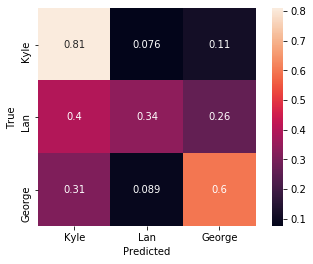

In [7]:
X_train, X_test, y_train, y_test = train_test_split(data.loc[:,'0'], 
                                                    data.loc[:,'1'], 
                                                    test_size=0.20, random_state=0)

# set up data generators
train_generator = tfidf_generator(tfidf, dictionary, X_train, y_train)
test_generator = tfidf_generator(tfidf, dictionary, X_test, y_test)

# train the model
tfidf_model.fit(train_generator)

# evaluate the model
y_pred = tfidf_model.predict(test_generator)
cm(test_generator.get_y_true(), np.argmax(y_pred, axis=1))

The result here is ok, it's better than 1/3 random chance and so at ~65% it's halfway there(?). It seems to be favouring Kyle in the confusion matrix, so let's try balance the data.

In [8]:
data['1'].value_counts()

Kyle      634
Lan       323
George    261
Name: 1, dtype: int64

In [9]:
def balanced_sample_maker(X, y, sample_size, random_seed=None):
    """ return a balanced data set by sampling all classes with sample_size 
        current version is developed on assumption that the positive
        class is the minority.
        
    Author: Kevin Mader on StackOverflow

    Parameters:
    ===========
    X: {numpy.ndarrray}
    y: {numpy.ndarray}
    """
    uniq_levels = np.unique(y)
    uniq_counts = {level: sum(y == level) for level in uniq_levels}

    if not random_seed is None:
        np.random.seed(random_seed)

    # find observation index of each class levels
    groupby_levels = {}
    for ii, level in enumerate(uniq_levels):
        obs_idx = [idx for idx, val in enumerate(y) if val == level]
        groupby_levels[level] = obs_idx
    # oversampling on observations of each label
    balanced_copy_idx = []
    for gb_level, gb_idx in groupby_levels.items():
        over_sample_idx = np.random.choice(gb_idx, size=sample_size, replace=True).tolist()
        balanced_copy_idx+=over_sample_idx
    np.random.shuffle(balanced_copy_idx)

    return X.iloc[balanced_copy_idx], y.iloc[balanced_copy_idx], balanced_copy_idx

  ...
    to  
  ['...']
Train for 626 steps
Epoch 1/2
626/626 [==============================] - 4s 6ms/step - loss: 0.9645 - accuracy: 0.5463
Epoch 2/2
626/626 [==============================] - 3s 5ms/step - loss: 0.4033 - accuracy: 0.8626
Test accuracy: 0.76


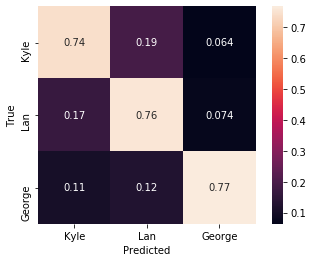

In [10]:
balanced_tfidf_model = Sequential(
    [
        Input(shape=(2084,)),
        Dense(200, activation="relu", name="layer1"),
        Dense(3, name="output", activation="softmax"),
    ]
)
balanced_tfidf_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

X, y, _ = balanced_sample_maker(data.loc[:,'0'], data.loc[:,'1'], 261)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)

# set up data generators
train_generator = tfidf_generator(tfidf, dictionary, X_train, y_train)
test_generator = tfidf_generator(tfidf, dictionary, X_test, y_test)

# train the model
balanced_tfidf_model.fit(train_generator, epochs=2)

# evaluate the model
y_pred = balanced_tfidf_model.predict(test_generator)
cm(test_generator.get_y_true(), np.argmax(y_pred, axis=1))

That's an improvement! Far fewer false-positives.

Now lets try something more sophisticated:

## Training a NN with BERT-Generated Vectors

In [11]:
bert_urls = ["bert vectors/adversarial-examples-protein-folding-and-shaley-values_bert.csv",
            "bert vectors/dark-secrets-of-bert-radioactive-data-and-vanishing-gradients_bert.csv",
            "bert vectors/ep1_bert.csv",
            "bert vectors/intro-narration-raw_bert.csv",
            "bert vectors/JC-EP-12_bert.csv",
            "bert vectors/JC-Ep2-DS-Page_bert.csv"]

data = pd.read_csv(bert_urls[0])

for url in bert_urls[1:]:
    data_m = pd.read_csv(url)
    data = pd.concat([data, data_m])

Using the [BERT Language Model](http://jalammar.github.io/a-visual-guide-to-using-bert-for-the-first-time/) I generated vector representations of our entire corpus. 

In [12]:
data.head()

,0,1,2,3,4,5,6,7,8,9,...,759,760,761,762,763,764,765,766,767,label
0,-0.050656,-0.097459,0.152361,-0.114675,-0.101158,-0.315727,0.340263,0.564517,0.009753,-0.314720,...,-0.101649,-0.018223,-0.383690,0.211063,-0.068506,-0.203341,0.049656,0.611221,0.287434,Kyle
1,0.022924,0.124248,-0.040365,-0.102556,-0.158542,-0.267900,0.242012,0.626368,-0.294723,-0.409109,...,-0.135764,-0.097523,-0.273424,0.207192,0.044909,-0.195405,-0.030666,0.407373,0.265958,Lan
2,0.183041,-0.048330,0.123398,-0.294040,-0.093102,-0.226358,0.095844,0.419580,-0.141061,-0.157787,...,-0.212796,0.047362,-0.286696,0.213806,0.049149,-0.271264,-0.012782,0.381192,0.331348,George
3,0.023248,0.002814,0.056239,0.042267,-0.128903,-0.382420,0.172569,0.391190,-0.270455,-0.266405,...,-0.203693,-0.068308,-0.356595,0.069920,0.136549,-0.145512,-0.160707,0.553683,0.272639,Kyle
4,-0.032686,0.036833,0.035956,-0.028957,-0.107845,-0.236589,0.044480,0.251513,-0.177570,-0.329692,...,-0.234491,0.023923,-0.103210,0.026622,0.132827,-0.134265,-0.235072,0.339977,0.422955,Lan


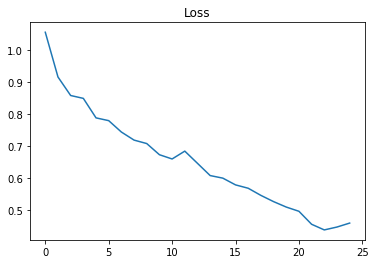

Test accuracy: 0.66


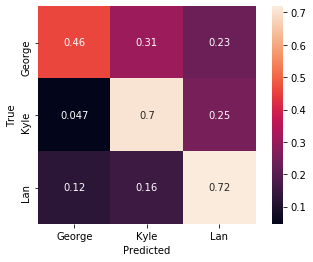

In [68]:
bert_model = Sequential(
    [
        Input(shape=(768,)),
        Dense(200, name="layer1", activation="relu"),
        Dense(3, name="output", activation="softmax"),
    ]
)
bert_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

tidy_data = pd.get_dummies(data)

X_train, X_test, y_train, y_test = train_test_split(tidy_data.loc[:,'0':'767'], 
                                                    tidy_data.loc[:,'label_George':'label_Lan'], 
                                                    test_size=0.10, random_state=0, 
                                                    stratify=tidy_data.loc[:,'label_George':'label_Lan'])

history = bert_model.fit(X_train, y_train, epochs=25, verbose=0)
plt.plot(history.history['loss'])
plt.title("Loss")
plt.show()
y_pred = bert_model.predict(X_test)
cm(np.argmax(np.asarray(y_test), axis=1), np.argmax(y_pred, axis=1), names=["George", "Kyle", "Lan"])

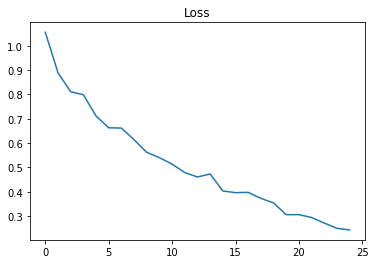

Test accuracy: 0.68


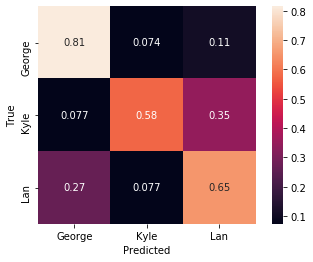

In [69]:
balanced_bert_model = Sequential(
    [
        Input(shape=(768,)),
        Dense(200, name="layer1", activation="relu"),
        Dense(3, name="output", activation="softmax"),
    ]
)
balanced_bert_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

X, y, _ = balanced_sample_maker(data.loc[:,'0':'767'], 
                                data.loc[:,'label'], 261)
X_train, X_test, y_train, y_test = train_test_split(X, pd.get_dummies(y), 
                                                    test_size=0.10, random_state=0, stratify=y)

history = balanced_bert_model.fit(X_train, y_train, epochs=25, verbose=0)
plt.plot(history.history['loss'])
plt.title("Loss")
plt.show()
y_pred = balanced_bert_model.predict(X_test)
cm(np.argmax(np.asarray(y_test), axis=1), np.argmax(y_pred, axis=1), names=["George", "Kyle", "Lan"])

## Comparing our Models on a Target Document

In [16]:
url = "csvs/tools-for-misusing-gpt-2-tensorflow-and-ml-unfairness.csv"
bert_url = "bert vectors/tools-for-misusing-gpt-2-tensorflow-and-ml-unfairness_bert.csv"

UNBALANCED TF-IDF MODEL
Test accuracy: 0.55


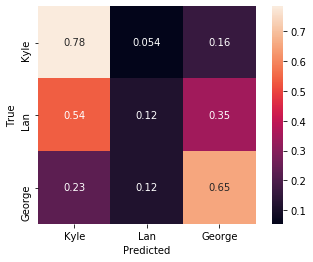

BALANCED TF-IDF MODEL
Test accuracy: 0.51


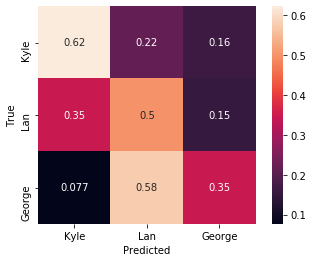

In [17]:
tfidf_data = pd.read_csv(url)
# set up data generator
target_generator = tfidf_generator(tfidf, dictionary, tfidf_data.loc[:,'0'], tfidf_data.loc[:,'1'])

# evaluate the tfidf model
print("UNBALANCED TF-IDF MODEL")
y_pred = tfidf_model.predict(target_generator)
cm(target_generator.get_y_true(), np.argmax(y_pred, axis=1))

# evaluate the balanced tfidf model
print("BALANCED TF-IDF MODEL")
y_pred = balanced_tfidf_model.predict(target_generator)
cm(target_generator.get_y_true(), np.argmax(y_pred, axis=1))

UNBALANCED BERT MODEL
Test accuracy: 0.54


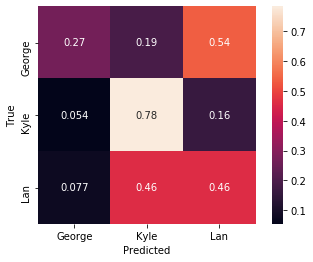

BALANCED BERT MODEL
Test accuracy: 0.54


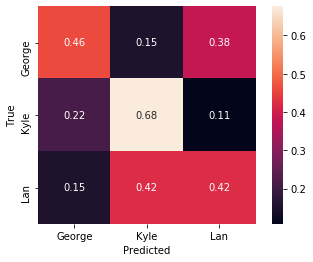

In [70]:
bert_data = pd.read_csv(bert_url)

tidy_bert_data = pd.get_dummies(bert_data)

X_train, X_test, y_train, y_test = train_test_split(tidy_data.loc[:,'0':'767'], 
                                                    tidy_data.loc[:,'label_George':'label_Lan'], 
                                                    test_size=0.20, random_state=0)

# evaluate the bert model
print("UNBALANCED BERT MODEL")
y_pred = bert_model.predict(tidy_bert_data.loc[:,'0':'767'])
cm(np.argmax(np.asarray(tidy_bert_data.loc[:,'label_George':'label_Lan']), axis=1), 
   np.argmax(y_pred, axis=1), names=["George", "Kyle", "Lan"])

# evaluate the balanced bert model
print("BALANCED BERT MODEL")
y_pred = balanced_bert_model.predict(tidy_bert_data.loc[:,'0':'767'])
cm(np.argmax(np.asarray(tidy_bert_data.loc[:,'label_George':'label_Lan']), axis=1), 
   np.argmax(y_pred, axis=1), names=["George", "Kyle", "Lan"])